# Dynamic Programming for the Recycle Robot Environment

(Implementation of Example 3.3 in Sutton & Barto textbook, 2nd edition.)

<img src="./images/RecyclingRobot_mod.jpg" 
     align="center" 
     width="800" />

### Imports

In [1]:
from gymnasium import Env, spaces
from gymnasium.envs.toy_text.utils import categorical_sample
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
random.seed(5)
%matplotlib inline

## Create MDP for the Recycling Robot

In [2]:
class RecycleEnv(Env):

    def __init__(self, alpha=0.5, beta=0.2, duration=20):
        self.observation_space = spaces.Discrete(2)  # 0: low 1: high
        self.action_space = spaces.Discrete(3)  # 0: search 1: wait 2: recharge

        r_search = 4
        r_wait = 1
        self.state = "high"
        self.sum = 0

        self.StateActionPairings = {"low": ["search", "wait", "recharge"],
                                    "high": ["search", "wait"]}

        # action: {state:[(nextstate, reward, probability, termination)]}
        self.TransitionStatesandProbs = {
            "wait": {
                "high": [("high", r_wait, 1, False)],
                "low": [("low", r_wait, 1, False)]
            },
            "recharge": {
                "low": [("high", 0, 1, False)]
            },
            "search": {
                "high": [("high", r_search, round(alpha, 1), False),
                         ("low", r_search, round(1-alpha, 1), False)],
                "low": [("low", r_search, round(beta, 1), False),
                        ("high", -3, round(1-beta, 1), False)]
            }}

    def reset(self, seed=None, options: Optional[dict] = None):
        self.state = "high"
        self.time = 0
        self.sum = 0
        print("Environment reset: Current state is High")
        return self.state, {}

    def step(self, a):
        transitions = self.TransitionStatesandProbs[a][self.state]
        i = categorical_sample([t[2] for t in transitions], self.np_random)
        s, r, p, t = transitions[i]
        self.SumReward(r)
        self.state = s
        return (s, r, t, False, {})

    def SumReward(self, reward=0):
        self.sum = self.sum + reward
        return self.sum

    def getPossibleActions(self, state):
        return self.StateActionPairings[state]

    def getTransitionStatesandProbs(self, state, action):
        return self.TransitionStatesandProbs[action][state]

## Agent using Value Iteration to find the optimal policy

In [3]:
class ValueIterationAgent():
    def __init__(self, env, discount=0.9, iterations=100, theta=0.01):
        self.name = "Value Iteration Agent"
        self.env = env
        self.discount = discount
        self.theta = theta
        self.V = {"low": 0, "high": 0}
        self.pi = {}

        # train
        self.train(iterations)

    def train(self, iterations):
        states = ["low", "high"]  # states are numbered
        for i in range(iterations):
            delta = 0

            for state in states:
                v = self.V[state]
                actions = self.env.getPossibleActions(state)
                action_value_list = []
                for action in actions:

                    ###################################################
                    # YOU WILL IMPLEMENT THIS FUNCTION IN TASK 1
                    q_val_for_given_action = self.calculate_q_value_estimate(state, action)
                    ###################################################

                    action_value_list.append(q_val_for_given_action)

                ###################################################
                # YOU WILL IMPLEMENT THIS FUNCTION IN TASK 2
                self.V[state] = self.update_state_value_function(action_value_list)  # max(value_list_for_actions)
                ###################################################

                ###################################################
                # YOU WILL IMPLEMENT THIS FUNCTION IN TASK 3
                delta = self.update_delta(delta, v, state)  # max(delta, abs(v - self.V[state]))
                ###################################################

                # explicit "policy improvement"
                self.pi[state] = actions[action_value_list.index(self.V[state])]

            # stopping criterion
            if delta < self.theta:
                print(f"Stopping criterion satisfied after {i} iterations.\n")
                print(f"Value function is: {self.V}\n")
                print(f"Optimal policy is: {self.pi}\n")
                break

    def getValue(self, state):
        return self.V[state]

    def getPolicy(self, state):
        return self.pi[state]

    def getAction(self, state):
        return self.getPolicy(state)

---
## Task 1

Your task is to implement the method `calculate_q_value` that takes as input a state and an action (see `ValueIterationAgent`).
In this method, there is already a loop implemented over all possible next states and their reward.
In the loop, you therefore have access to the transition probability $ p(s', r \mid s, a) $, here `trans_prob`, the next state $s'$, here `next_state`, and the reward $r$, here `reward`.

Based on these variables and the attributes of `ValueIterationAgent`, calculate the action-value function estimate of the current iteration.

_Hint: Note that the current state-value function estimate is stored in `self.V`._

In [4]:
def calculate_q_value_estimate(self, state, action):

    q = 0
    for sum_element in self.env.getTransitionStatesandProbs(state, action):

        # Extract information
        next_state = sum_element[0]  # next state s'
        reward = sum_element[1]  # reward r
        trans_prob = sum_element[2]  # transition probability p(s', r | s, a)

        # YOUR CODE HERE
        q += trans_prob * (reward + self.discount * self.V[next_state])

    return q


# This adds the function as a method to the specified class.
setattr(ValueIterationAgent, "calculate_q_value_estimate", calculate_q_value_estimate)

---
## Task 2

Your task is to implement the method `update_state_value_function` that takes as input a list of action-value functions estimates $q(s,a)$ for all actions given the state $s$ (see `ValueIterationAgent`).
Based on this list, calculate the state-value function $v(s)$.

In [5]:
def update_state_value_function(self, list_of_q_values):
    
    # YOUR CODE HERE
    return max(list_of_q_values)


# This adds the function as a method to the specified class.
setattr(ValueIterationAgent, "update_state_value_function", update_state_value_function)

---

## Task 3

Your task is to implement the method `update_delta` that takes as input the current $\Delta$, here `delta`, the state-value function before the update, here `v`, and the state, here `state`.
Based on this list, calculate the updated $\Delta$.

In [6]:
def update_delta(self, delta, v, state):

    # YOUR CODE HERE
    return max(delta, abs(v - self.V[state]))


# This adds the function as a method to the specified class.
setattr(ValueIterationAgent, "update_delta", update_delta)

## Dummy Agent using the random policy

In [7]:
class DummyAgent():
    def __init__(self, env):
        self.name = "Dummy Agent"
        self.env = env

    def getValue(self, state):
        pass

    def getPolicy(self, state):
        actions = self.env.getPossibleActions(state)
        return random.choice(actions)

    def getAction(self, state):
        return self.getPolicy(state)

### Define play-function

In [8]:
def play(agent, env, rounds=100):
    print("#"*10, "\n")
    print(f"Starting play with agent: {agent.name}\n")

    for round_no in range(rounds):
        current_state = env.state
        player_move = agent.getAction(current_state)
        next_state, r, t, _, _ = env.step(player_move)

        print(f"Round {round_no} \nAction: {player_move}\tReward: {r}\tNext State: {next_state}")
        img = Image.open("./images/"+current_state+"_"+player_move+"_"+next_state+".jpg")
        plt.figure(figsize=(10, 7))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        input("Press Enter to continue!")

    print(f"{rounds} Rounds Ended:\n")
    print(f"The agent collected a total return of {env.sum}\n")
    env.reset()
    print("#"*10, "\n")

## Dummy Agent

Test the behavior of a recycling robot with random actions.

In [9]:
env = RecycleEnv()

########## 

Starting play with agent: Dummy Agent

Round 0 
Action: wait	Reward: 1	Next State: high


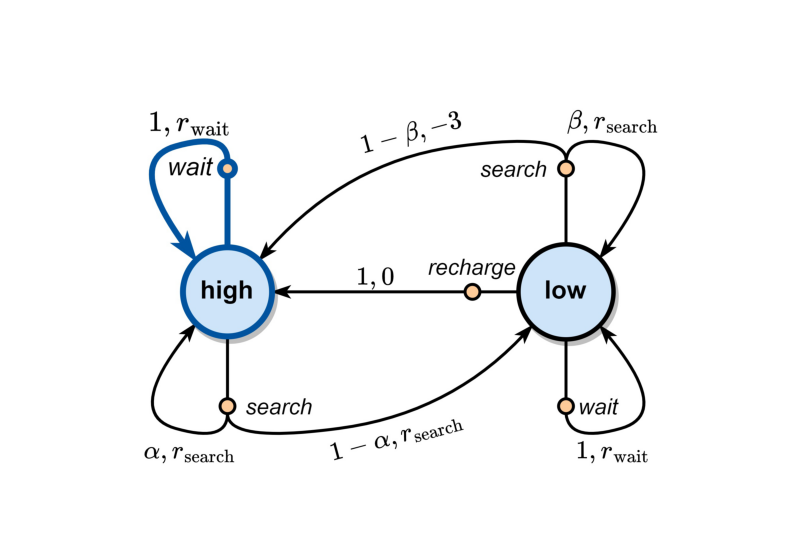

In [10]:
agent = DummyAgent(env)
play(agent, env, rounds=10)

## Value Iteration Agent

Test the optimal behavior of the recycling robot given the specified parametrization.

Stopping criterion satisfied after 39 iterations.

Value function is: {'low': 24.773480007530324, 'high': 27.534806007153808}

Optimal policy is: {'low': 'recharge', 'high': 'search'}

########## 

Starting play with agent: Value Iteration Agent

Round 0 
Action: search	Reward: 4	Next State: high


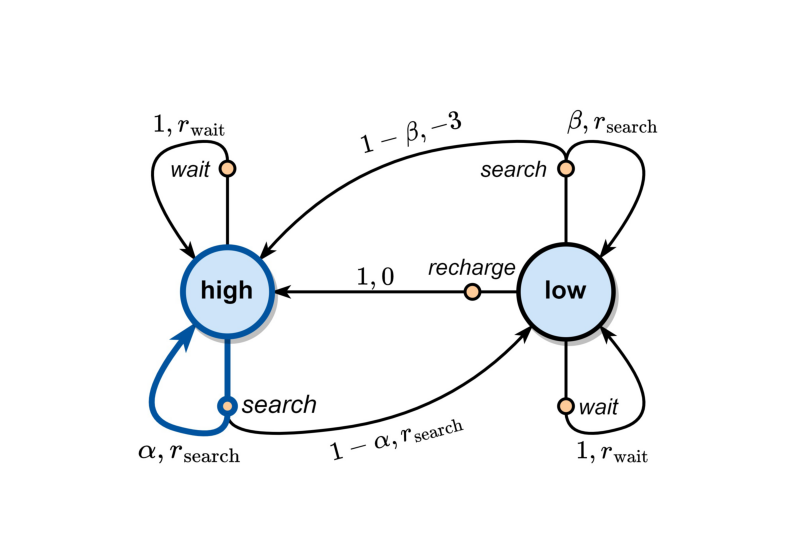

In [19]:
agent = ValueIterationAgent(env=env)
play(agent, env, rounds=10)

## Questions

**Question 1.** Suppose the reward for waiting is higher than for searching. What do you expect will happen to the value functions of the two states? What would be the optimal policy?

YOUR ANSWER HERE

---
Some of the coding examples in this MOOC are based on examples in “Reinforcement Learning: An Introduction”, Second Edition, MIT Press, 2018, by Richard S. Sutton and Andrew G. Barto under the license [CC-BY-NC-ND 2.0](https://creativecommons.org/licenses/by-nc-nd/2.0/).

The PDF is freely available online: http://incompleteideas.net/book/RLbook2018.pdf.

<center><img width="200"  align="right" src="attachment:7d6e0c10-34c6-4ebc-a4e6-606e7239f44d.png" /></center>

This work was originally created by Sebastian Trimpe and Paul Brunzema. <br> 
It is licensed under Attribution-ShareAlike 4.0 International [(CC-BY-SA 4.0)](https://creativecommons.org/licenses/by-sa/4.0/).

In [ ]:
class RecycleEnv(Env):
    def __init__(self, alpha=0.5,beta=0.2,duration=20):
        self.observation_space = spaces.Discrete(2) # 0:low 1:high
        self.action_space = spaces.Discrete(3) # 0:search 1:wait 2:recharge

        r_s = 4
        r_w = 1
        self.state = 1
        self.sum = 0
        # (action,state) : [(next_state,reward,probability)]
        self.transition_list = {
            (0,0): [(0,r_s,beta),(1,-3,1-beta)],
            (0,1):[(0,r_s,1-alpha),(1,r_s,alpha)],
            (1,0):[(0,r_w,1)],
            (1,1):[(1,r_w,1)],
            (2,0):[(1,0,1)],
        }
        self.state_pair = {0: [0, 1,2],
                           1: [0, 1]}


    def step(self,a):
        if (a,self.state) not in self.transition_list:
            raise ValueError("Invalid action")
        transitions = self.transition_list[(a,self.state)]
        i = categorical_sample([t[2] for t in transitions], self.np_random)
        s_prime, r, p = transitions[i]
        self.increase_sum(r)
        self.state = s_prime
        return s_prime, r, False, {}
        

    def reset(self, seed=None, options: Optional[dict] = None):
        self.state = 1
        self.time = 0
        self.sum = 0
        print("Environment reset: Current state is High")
        return self.state, {}

    def increase_sum(self,sum):
        self.sum += sum
    def get_possible_actions(self, state):
        return self.state_pair[state]

    def get_transition_state_and_probs(self, state, action):
        return self.transition_list[(action,state)]

In [ ]:
class ValueIterationAgent():
    def __init__(self,env,discount=0.9,theta=0.01):
        self.env = env
        self.discount = discount
        self.theta = theta
        self.values = {s: 0 for s in range(env.observation_space.n)}
        self.pi = {0:[0,1,2],1:[0,1]}
    

    def train(self, max_iterations=1000):
        for i in range(max_iterations):
            delta = 0
            for s in range(self.env.observation_space.n):
                v = self.values[s]
                self.values[s] = self.get_max_q(s)
                delta = max(delta,abs(v-self.values[s]))
            if delta < self.theta:
                break
    

    def get_max_q(self,s):
        q_values = []
        for a in self.env.get_possible_actions(s):
            q = self.get_q(s,a)
            q_values.append(q)
    
        return max(q_values)

    def get_q(self,s,a):
        q = 0
        for s_prime,r,p in self.env.get_transition_state_and_probs(s,a):
            q += p*(r+self.discount*self.values[s_prime])
        return q
